# Milestone-2: Regression

This notebook corresponds to the second stage of the Machine Learning final project, as part of the Copernicus Master in Digital Earth, in the Data Science track at UBS by Candela Sol PELLIZA & Rajeswari PARASA.

The project is focused on properties' price prediction for the city of Ames, Iowa, Us. The present Notebook contains two parts: 
1. The first part corresponds to some updates and corrections in the preprocessing and splitting of data that was proposed in the previous stage, ending with the updated, ready-to-work training and test sets.
2. The second part corresponds to the specific tasks of regression, following the requirements of milestone 2

# PART 1: UPDATES ON PREPROCESSING STEPS FROM MILESTONE 1

The observations we got from the milestone-1 notebook, mainly regarding the splitting of data and some minor preprocessing steps, made us consider that we needed to change the way we were splitting the data into train and test. Considering that this step was performed at the very beginning of the previous notebook, with the purpose of avoiding data leakage in the preprocessing, redoing the train-test split implies also redoing the preprocessing steps.

Having this situation in mind, this first part of the notebook will present in detail the new changes we decided to include, in terms of both data splitting and preprocessing. However, for the rest of preprocessing steps, as they were already explained and justified in the previous notebook, they will be added here to include the whole workflow, but not explained again.

#### 1.a. Loading libraries and importing the original dataset

In [2]:
#Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
#Setting pandas to show all the columns
pd.set_option('display.max_columns', None)

In [7]:
#Importing  and visualizing the dataset
data = pd.read_csv('OpenData/Ames.csv')
data.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


#### 1.b. First preprocessing steps

In [8]:
#Create a dictionary with the old and new variable's names
RenameMapping = {
    'area': 'BldgArea',
    'price': 'SoldPrice',
    'MS.SubClass': 'MSSubClass',
    'MS.Zoning': 'MSZoning',
    'Lot.Frontage': 'LotFrontage',
    'Lot.Area': 'LotArea',
    'Lot.Shape': 'LotShape',
    'Land.Contour': 'LandContour',
    'Lot.Config': 'LotConfig',
    'Land.Slope': 'LandSlope',
    'Condition.1': 'Condition1',
    'Condition.2': 'Condition2',
    'Bldg.Type': 'BldgType',
    'House.Style': 'HouseStyle',
    'Overall.Qual': 'OverallQual',
    'Overall.Cond': 'OverallCond',
    'Year.Built': 'YearBuilt',
    'Year.Remod.Add': 'YearRemodAdd',
    'Roof.Style': 'RoofStyle',
    'Roof.Matl': 'RoofMatl',
    'Exterior.1st': 'Exterior1st',
    'Exterior.2nd': 'Exterior2nd',
    'Mas.Vnr.Type': 'MasVnrType',
    'Mas.Vnr.Area': 'MasVnrArea',
    'Exter.Qual': 'ExterQual',
    'Exter.Cond': 'ExterCond',
    'Bsmt.Qual': 'BsmtQual',
    'Bsmt.Cond': 'BsmtCond',
    'Bsmt.Exposure': 'BsmtExposure',
    'BsmtFin.Type.1': 'BsmtFinType1',
    'BsmtFin.SF.1': 'BsmtFinSF1',
    'BsmtFin.Type.2': 'BsmtFinType2',
    'BsmtFin.SF.2': 'BsmtFinSF2',
    'Bsmt.Unf.SF': 'BsmtUnfSF',
    'Total.Bsmt.SF': 'TotalBsmtSF',
    'Heating.QC': 'HeatingQual',
    'Central.Air': 'CentralAir',
    '1st.Flr.SF': '1stFlrSF',
    '2nd.Flr.SF': '2ndFlrSF',
    'Low.Qual.Fin.SF': 'LowQualFinSF',
    'Bsmt.Full.Bath': 'BsmtFullBath',
    'Bsmt.Half.Bath': 'BsmtHalfBath',
    'Full.Bath': 'FullBath',
    'Half.Bath': 'HalfBath',
    'Kitchen.Qual': 'KitchenQual',
    'TotRms.AbvGrd': 'TotRmsAbvGrd',
    'Fireplaces': 'Fireplaces',
    'Fireplace.Qu': 'FireplaceQu',
    'Garage.Type': 'GarageType',
    'Garage.Yr.Blt': 'GarageYrBlt',
    'Garage.Finish': 'GarageFinish',
    'Garage.Cars': 'GarageCars',
    'Garage.Area': 'GarageArea',
    'Garage.Qual': 'GarageQual',
    'Garage.Cond': 'GarageCond',
    'Paved.Drive': 'PavedDrive',
    'Wood.Deck.SF': 'WoodDeckSF',
    'Open.Porch.SF': 'OpenPorchSF',
    'Enclosed.Porch': 'EnclosedPorchSF',
    '3Ssn.Porch': '3SsnPorchSF',
    'Screen.Porch': 'ScreenPorchSF',
    'Pool.Area': 'PoolArea',
    'Pool.QC': 'PoolQual',
    'Misc.Feature': 'MiscFeature',
    'Misc.Val': 'MiscVal',
    'Mo.Sold': 'MoSold',
    'Yr.Sold': 'YrSold',
    'Sale.Type': 'SaleType',
    'Sale.Condition': 'SaleCondition',
    'X1st.Flr.SF': 'X1FloorSF',
    'X2nd.Flr.SF': 'X2FloorSF',
    'X3Ssn.Porch': '3SsnPorchSF',
    'Kitchen.AbvGr': 'KitchenAbvGr',
    'Bedroom.AbvGr': 'BedroomAbvGr',
    }

#Applying the name change
data.rename(columns=RenameMapping, inplace=True)

#Dropping 'Order' column
data = data.drop('Order', axis=1)

#### 1.c. Data Split into Train and Test

After reviewing the train & test data split performed in milestone 1, we realised that the unbalanced spatial distribution of samples had not been taken into account properly. The spatial attribute of our data is given by the "neighborhood" variable.
The barplot below shows the amount of samples belonging to each neighborhood in the original dataset.

<Axes: >

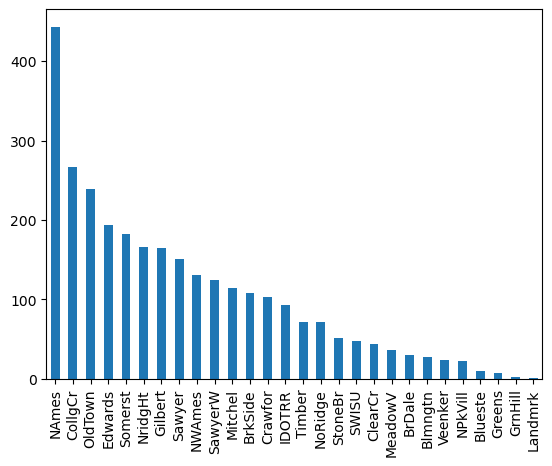

In [9]:
data['Neighborhood'].value_counts().plot(kind='bar')

The barplot gives meaningful information about two things. The first one is that the neighborhoods "GrnHill" and "Landmrk" have very few samples (1 and 2 respectively). The second one is that the neighborhoods' samples distribution is clearly unbalanced.

To solve the first issue, the rows corresponding to the mentioned neighborhoods will be dropped, given that such a small number can not be representative.

In [10]:
# Counting the number of samples
landmrk_smp = len(data[data['Neighborhood'] == 'Landmrk'])
print(f'Landmrk samples: {landmrk_smp}')

GrnHill_smp = len(data[data['Neighborhood'] == 'GrnHill'])
print(f'GrnHill samples: {GrnHill_smp}')

Landmrk samples: 1
GrnHill samples: 2


In [11]:
# Dropping the lines for Landmrk and GrnHill neighborhoods
neighb_todrop = ['Landmrk', 'GrnHill']
data = data[~data['Neighborhood'].isin(neighb_todrop)]

The next step is to handle the unbalanced neighborhoods' samples sdistribution. Considering that location is a key aspect on defining the price of a property, and taking into account the spatial autocorrelation effect, it is crucial to have a balanced distribution of samples from the different neighborhoods in our training and test datasets. This is specially important for the generalization of the model to unseen data, and also to take into account the influence of the spatial aspect.

When checking how the random split used in the previous notebook was handling this issue, we realised that the distribution was not balanced, specially for the classes with few samples. This can be confirmed in the graph below, which shows the neighborhood samples distribution in training and test dataset for the random technique previously adopted

In [16]:
#Divide data into train and test following the previously adopted technique
data_train_prev, data_test_prev = train_test_split(data, test_size=0.2, random_state=33)

# We use test_size =0.2 to indicate 20% of the data is used for testing and 80% for training
# We use random_state = 33 to ensure that the same random split is reproduced every time

In [21]:
def samples_neighb(data_train, data_test, technique):
    # Count samples by neighborhood in train and test sets
    train_counts = data_train['Neighborhood'].value_counts().reset_index()
    test_counts = data_test['Neighborhood'].value_counts().reset_index()

    # Merge the counts based on the 'Neighborhood' column
    combined_counts = pd.merge(train_counts, test_counts, on='Neighborhood', how='outer')

    # Plot
    ax=combined_counts.plot(x='Neighborhood', kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.title(f'Comparison of Train and Test Samples by Neighborhood {technique} splitting')
    plt.legend(["Train", "Test"])
    plt.show()

samples_neighb(data_train_prev, data_test_prev, technique='random')

TypeError: no numeric data to plot

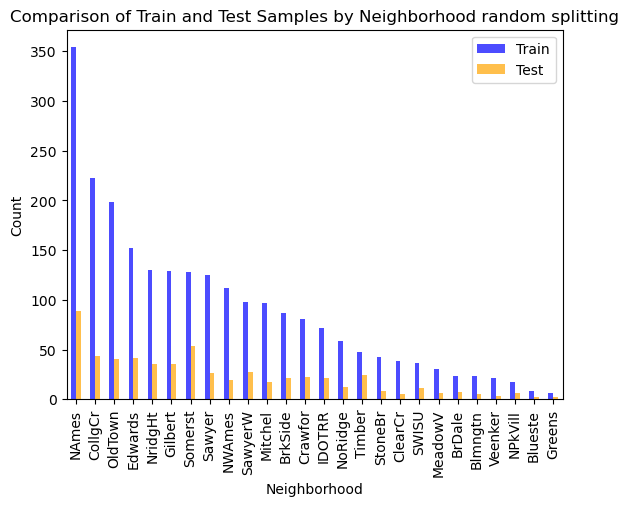

----------Proportions of samples from neighborhoods---------
      index  train_prop %  test_prop %
0     NAmes          15.1         15.2
1   CollgCr           9.5          7.5
2   OldTown           8.5          7.0
3   Edwards           6.5          7.2
4   NridgHt           5.6          6.1
5   Gilbert           5.5          6.1
6   Somerst           5.5          9.2
7    Sawyer           5.3          4.4
8    NWAmes           4.8          3.2
9   SawyerW           4.2          4.6
10  Mitchel           4.1          2.9
11  BrkSide           3.7          3.6
12  Crawfor           3.5          3.8
13   IDOTRR           3.1          3.6
14  NoRidge           2.5          2.0
15   Timber           2.1          4.1
16  StoneBr           1.8          1.4
17  ClearCr           1.7          0.9
18    SWISU           1.6          1.9
19  MeadowV           1.3          1.0
20   BrDale           1.0          1.2
21  Blmngtn           1.0          0.9
22  Veenker           0.9          0.5
23 

In [13]:
# Function to plot double bar graphs to compare the distribution of neighborhoods in train and test sets
def samples_neighb(data_train, data_test, technique):
    # Count samples by neighborhood in train and test sets
    train_counts = data_train['Neighborhood'].value_counts().reset_index()
    test_counts = data_test['Neighborhood'].value_counts().reset_index()
    # print(train_counts)

    # Merge the counts based on the 'Neighborhood' column
    combined_counts = pd.merge(train_counts, test_counts, on='index', how='outer')
    # print(combined_counts)
    
    # Plot
    ax=combined_counts.plot(x='index', kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.title(f'Comparison of Train and Test Samples by Neighborhood {technique} splitting')
    plt.legend(["Train", "Test"])
    plt.show()

    # Propotions as percentages
    combined_counts['train_prop %'] = round(combined_counts['Neighborhood_x'] *100/ combined_counts['Neighborhood_x'].sum(),1)
    combined_counts['test_prop %'] = round(combined_counts['Neighborhood_y']*100 / combined_counts['Neighborhood_y'].sum(),1)
    print('----------Proportions of samples from neighborhoods---------')
    print(combined_counts[['index', 'train_prop %', 'test_prop %']])


samples_neighb(data_train_prev, data_test_prev, technique='random')

To guarantee a balanced distribution of neighborhoods' samples between training and test datasets, we will perform an stratified split for the neighborhood variable, by means of the "stratify" parameter in the scikitlearn train_test_split() function.

In [17]:
# Divide data into train and test with stratified split
data_train, data_test= train_test_split(data, test_size=0.2, random_state=33, stratify=data['Neighborhood'])

The plot below shows the distribution of neighborhoods' samples in training and test data after the stratified split, with a proportional amount of samples for each neighborhood.

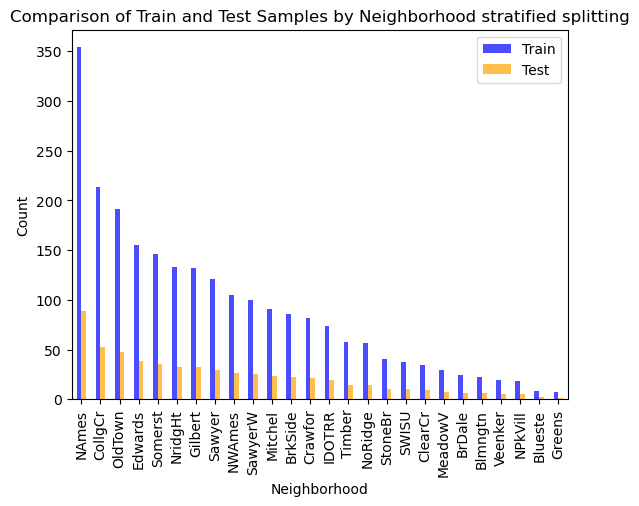

----------Proportions of samples from neighborhoods---------
      index  train_prop %  test_prop %
0     NAmes          15.1         15.2
1   CollgCr           9.1          9.0
2   OldTown           8.2          8.2
3   Edwards           6.6          6.7
4   Somerst           6.2          6.1
5   NridgHt           5.7          5.6
6   Gilbert           5.6          5.6
7    Sawyer           5.2          5.1
8    NWAmes           4.5          4.4
9   SawyerW           4.3          4.3
10  Mitchel           3.9          3.9
11  BrkSide           3.7          3.8
12  Crawfor           3.5          3.6
13   IDOTRR           3.2          3.2
14   Timber           2.5          2.4
15  NoRidge           2.4          2.4
16  StoneBr           1.8          1.7
17    SWISU           1.6          1.7
18  ClearCr           1.5          1.5
19  MeadowV           1.3          1.2
20   BrDale           1.0          1.0
21  Blmngtn           0.9          1.0
22  Veenker           0.8          0.9
23 

In [18]:
samples_neighb(data_train, data_test, technique='stratified')

#### 1.d. Post data-splitting Preprocessing

The following blocks of code contain all the preprocessing steps that the dataset requires, such as variables encoding and NA values handling, which were described in detail in the Milestone-1 notebook. For more information on the reasons, steps and parameters, refer to this notebook [## COMPLETE]

##### 1.d.1. Variables Encoding

In [19]:
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQual', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQual', 'Fence', 'PavedDrive' ]
binary = ['Street', 'CentralAir']
nominal = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
other = ['Alley']

Encoding Ordinal variables

In [20]:
# Mapping dictionary
variable_mappings = {
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'HeatingQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Na': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2}
}

# List of columns to map
columns_to_map = variable_mappings.keys()

def apply_mappings(data):
    for column in columns_to_map:
        data[column] = data[column].map(variable_mappings[column])

# Applying changes to training dataset
apply_mappings(data_train)

# Applying changes to test dataset
apply_mappings(data_test)

In [21]:
# Iterate through the columns in the 'ordinal' list and fill NA values with 0

#Applying changes to training dataset
for column in ordinal:
    data_train[column].fillna(0, inplace=True)

#Applying changes to test dataset
for column in ordinal:
    data_test[column].fillna(0, inplace=True)

Encoding binary variables

In [22]:
#Convert binary variables into numerical

Street = {'Grvl': 0, 'Pave': 1}
CentralAir = {'N': 0, 'Y': 1}

#Applying changes to training dataset
data_train['Street'] = data_train['Street'].map(Street)
data_train['CentralAir'] = data_train['CentralAir'].map(CentralAir)

#Applying changes to test dataset

data_test['Street'] = data_test['Street'].map(Street)
data_test['CentralAir'] = data_test['CentralAir'].map(CentralAir)

In [23]:
#Encode
Alley = {'Grvl': 1, 'Pave': 1, 'NA': 0}

#Applying changes to training dataset

data_train['Alley'] = data_train['Alley'].map(Alley)

#Fill NA
data_train['Alley'].fillna(0, inplace=True)

#Applying changes to test dataset

data_test['Alley'] = data_test['Alley'].map(Alley)

#Fill NA
data_test['Alley'].fillna(0, inplace=True)

##### 1.d.2. Handling NA Values

In [24]:
#Filling NAs on training
data_train['MiscFeature'].fillna('None', inplace=True)
data_train['GarageType'].fillna('None', inplace=True)

#Filling NAs on test
data_test['MiscFeature'].fillna('None', inplace=True)
data_test['GarageType'].fillna('None', inplace=True)

In [25]:
# Drop rows with NaN values in specific columns in training
columns_to_check = ['MasVnrType' , 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'Electrical', 'GarageArea']
data_train.dropna(subset=columns_to_check, inplace=True)

# Drop rows with NaN values in specific columns in test
data_test.dropna(subset=columns_to_check, inplace=True)

In [26]:
## LotFrontage VARIABLE

#Fill Na values with column mean - training
mean_LotFrontage_train = data_train['LotFrontage'].mean()
data_train['LotFrontage'].fillna(mean_LotFrontage_train, inplace=True)

#Fill Na values with column mean - test
mean_LotFrontage_test = data_test['LotFrontage'].mean()
data_test['LotFrontage'].fillna(mean_LotFrontage_test, inplace=True)

In [27]:
## GarageYrBlt VARIABLE

#Filling GarageYrBlt NA values with YearBuilt in training
data_train['GarageYrBlt'].fillna(data_train['YearBuilt'], inplace=True)

#Filling GarageYrBlt NA values with YearBuilt in test
data_test['GarageYrBlt'].fillna(data_test['YearBuilt'], inplace=True)


##### 1.d.3. Encoding Categorical Variables

In [28]:
# Perform one-hot encoding (returns True/False values) in training
data_train = pd.get_dummies(data_train, columns=nominal, prefix=nominal, dtype=int)

# Perform one-hot encoding (returns True/False values) in test
data_test = pd.get_dummies(data_test, columns=nominal, prefix=nominal, dtype=int)


In [29]:
data_train.head()

,PID,BldgArea,SoldPrice,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQual,CentralAir,X1FloorSF,X2FloorSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorchSF,3SsnPorchSF,ScreenPorchSF,PoolArea,PoolQual,Fence,MiscVal,MoSold,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_A (agr),MSZoning_C (all),MSZoning_FV,MSZoning_I (all),MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_PreCast,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_PreCast,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_CBlock,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Elev,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_VWD,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
174,902125080,1605,107400,60.000000,5790,1,0.0,4,4,1,3,6,1915,1950,0.0,4.0,4.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0,840.0,840.0,4,0,840,765,0,0.0,0.0,2,0,3,2,3,8,8,0,0.0,1915.0,1.0,1.0,379.0,3.0,3.0,2,0,0,2

##### 1.d.4. Columns dropping

According to what was observed in the previous milestone, there are a some columns for which all the values are equal to zero (as observed in the previous notebook's correlation matrix), resulting not significant for the analysis. These columns are dropped from both the training and test datasets.

In [60]:
# Create a list of dropped columns
drop_columns = []

# Iterate over data_train and drop columns
for column in data_train.columns:
    count_no0 = (data_train[column] != 0).sum()
    if count_no0 < 1:
        data_train.drop(column, axis=1, inplace=True)
        drop_columns.append(column)

print(drop_columns)

[]


In [239]:
# Dropping columns in test dataset
data_test.drop(drop_columns, axis=1)

,PID,BldgArea,SoldPrice,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQual,CentralAir,X1FloorSF,X2FloorSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorchSF,3SsnPorchSF,ScreenPorchSF,PoolArea,PoolQual,Fence,MiscVal,MoSold,YrSold,MSSubClass_20,MSSubClass_30,MSSubClass_50,MSSubClass_60,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAn,Condition1_RRNe,Condition2_Norm,Condition2_RRAn,BldgType_1Fam,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Mansard,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Tar&Grv,RoofMatl_WdShake,Exterior1st_AsbShng,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Heating_GasA,Heating_GasW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLw,SaleType_New,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
2510,533221080,1524,166000,75.956284,2998,1,0.0,4,4,1,6,5,2000,2000,513.0,4.0,0.0,5.0,0.0,0.0,6.0,353.0,1.0,0.0,403.0,756.0,5,1,768,756,0.0,0.0,2,1,2,1,4,4,8,0,0.0,2000.0,1.0,2.0,440.0,3.0,3.0,2,0,32,0,0,0,0,0.0,0.0,0,6,2006,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
430,528108140,2020,402861,94.000000,12220,1,0.0,4,4,1,10,5,2009,2009,305.0,5.0,0.0,6.0,0.0,0.0,6.0,1436.0,1.0,0.0,570.0,2006.0,5,1,2020,0,1.0,0.0,2,1,3,1,5,9,8,1,4.0,2009.0,3.0,3.0,900.0,3.0,3.0,2,156,54,0,0,0,0,0.0,0.0,0,9,2009,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2900,916477010,1960,320000,95.000000,13618,1,0.0,4,4,1,8,5,2005,2006,198.0,4.0,0.0,6.0,5.0,0.0,6.0,1350.0,1.0,0.0,378.0,1728.0,5,1,1960,0,1.0,0.0,2,0,3,1,4,8,8,2,4.0,2005.0,3.0,3.0,714.0,3.0,3.0,2,172,38,0,0,0

#### Proposed 1.d.4. Columns dropping

In the previous milestone, we observed that, the correlation matrix has two rows with `nan` values for all cells. Upon inspection of the corresponding features, we realised that they have the same value for all samples. This is not significant for the analysis, so we decided to drop these columns from both the training and test datasets.

In [30]:
# List of colunmns with only 1 value for all rows in test
def singlevalue_columns(data):
    # Create a list of single-valued columns
    singlevalue_cols = []
    for i in data.columns:
        if data[i].nunique() <2:
            singlevalue_cols.append(i)
    #print(f'Columns with only 1 value: {singlevalue_cols}')
    return singlevalue_cols

drop_cols = singlevalue_columns(data_train)
print(drop_cols)

[]


In [ ]:
# Dropping columns in train dataset
data_train.drop(drop_cols, axis=1, inplace=True)

# Dropping columns in test dataset
data_test.drop(drop_cols, axis=1, inplace=True)

#### 3.d. Processed datasets exporting
After processing both training and test datasets, we export them as csv files. It is improtant to notice that the normalization step that will be performed later should also be done for the testing set when running the models.


In [31]:
# Exporting training datset
data_train.to_csv('OpenData/ames_train_clean.csv', index=False)

# Exporting test datset
data_test.to_csv('OpenData/ames_test_clean.csv', index=False)

# LOG TRANSFORMATION - DEFIEN IF WE DO IT
We can see that the distribution of the target variable is right skewed, with a long tail on the right side. This indicates that there are some outliers in the dataset. Further, we can see that the distribution is not normal, and that the mean is higher than the median, which indicates that the distribution is positively skewed. So we may have to transform the target variable to get a normal distribution before applying linear regression.

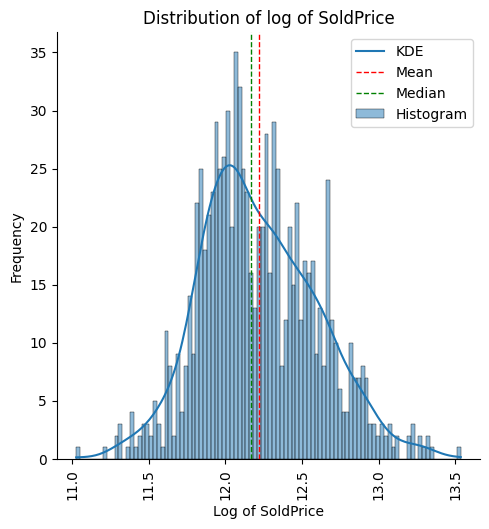

In [40]:
# Applying log transformation to SoldPrice
sns.displot(np.log(data_train['SoldPrice']), bins=100, kde=True)

plt.xticks(rotation=90)
# Plot mean and median lines
plt.axvline(np.log(data_train['SoldPrice']).mean(), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.log(data_train['SoldPrice']).median(), color='green', linestyle='dashed', linewidth=1)

plt.title('Distribution of log of SoldPrice')
plt.xlabel('Log of SoldPrice')
plt.ylabel('Frequency')
plt.legend({'KDE':np.log(data_train['SoldPrice']),'Mean':np.log(data_train['SoldPrice']).mean(), 'Median': np.log(data_train['SoldPrice']).median(), 'Histogram':np.log(data_train['SoldPrice'])})
plt.show()


Since applying the log transformation to the target variable is making it more normally distributed, i.e. symmetrical around the mean, we may want to **apply this transformation to the target variable before applying linear regression.** However, we will not do this at this stage, and will revisit this in the next stage of the project after building a richer understanding of the data and model- such as effect of the log transformation on the model performance, potential transformations on explanatory variables.

One more way to verify if the target variable is normally distributed is by plotting the QQ plot. The QQ plot shows the quantiles of the target variable against the quantiles of a normal distribution. If the target variable is normally distributed, the points will fall on a straight line. 

# OUTLIERS -DEFINE IF WE DO IT
Since we see the BldgArea to be the highest correlated 'continuous' variable, we can use that in combination with the SalesPrice to identify and remove our outliers.

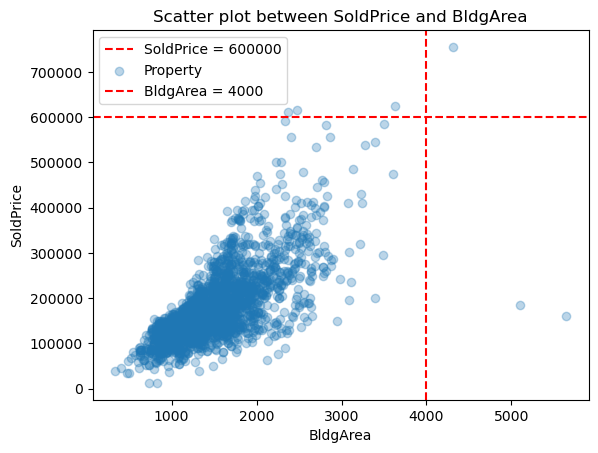

In [ ]:
# scatter plot between soldprice and bldgarea
plt.scatter(data_train['BldgArea'], data_train['SoldPrice'], alpha=0.3, label = 'Property')
plt.xlabel('BldgArea')
# referece lines x = 4000 and y = 600000
plt.axvline(4000, color='red', linestyle='dashed', label='BldgArea = 4000')
plt.axhline(600000, color='red', linestyle='dashed', label='SoldPrice = 600000')

plt.ylabel('SoldPrice')
plt.title('Scatter plot between SoldPrice and BldgArea')
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.show()


In [ ]:
# Run this code block to drop outliers
data_train.drop(data_train[data_train['BldgArea'] > 4000].index, inplace=True)
data_train.drop(data_train[data_train['SoldPrice'] > 600000].index, inplace=True)
data_train.shape

(2316, 246)

# REVISIT THIS TO DEFINE THE METRICS (ACCORDING TO LOG TRANSFORM)

#### 6.b. Evaluation metric

Since our problem is defined as a regression problem (predicting "SalePrice"), we will restrict our evaluation metrics to those that adapt to this kind of problems.
We will consider Root Mean Squared Logarithmic Error (RMSLE) as the main metric, given the wide range of values in our target variable. Being a lograithmic measure, it ensures that the errors for high and low prices properties are considered equally. Moreover, it also accounts for the skewed distribution of the prediction variable, as in our case, which is rigth skewed, allowing the algorithm to focus on the errors in a more common range of distribution.

Moreover, we will take into account two auxiliar metrics:

- RSME given that it provides a good measure of how far the predicted values are from the groundtruth values, providing the error value in the same unit scale as the target variable. Being our prediction in a currency unit, this allows an easy interpretability of the results. 

- R2 in order to allow for a standardised comparison. It gives a measure of how much of the variance in the data is explained by the model, and allows comparing the results with other models in a range from 0-1. 


#### Proposed 6.b. Evaluation metric

Since our problem is defined as a regression problem (predicting "SalePrice"), we will restrict our evaluation metrics to those that adapt to this kind of problems.

After reconciling our observations from the exploratory data analysis in the previous milestone and the feedback received from the mentors, we will consider Root Mean Squared Logarithmic Error as the main metric. This is due to the following reasons:
1. The target variable is right skewed and hence not normally distributed. 
2. There are outliers in the data. 

Based on literature that we encountered on the RMSLE metric, is robust to outliers ([Saxena, 2019](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a); [Sagi, 2023](https://help.pecan.ai/en/articles/6456388-model-performance-metrics-for-regression-models#Modelperformancemetricsforregressionmodels-RootMeanSquaredLogarithmicError(RMSLE))) and is suitable for non-normally distributed or skewed data [(Hussain, 2022)](https://techwithshadab.medium.com/root-mean-squared-error-root-mean-squared-logarithmic-error-70e645efcccb). This is because RMSLE measures the relative distance of the predicted value from the actual value, unlike RMSE which measures the absolute distance. Due to this, RMSE can be heavily affected by the outliers, the range of the target variable and the distribution of the target variable.

Moreover, we will take into account two auxiliary metrics:

- RSME given that it provides a good measure of how far the predicted values are from the groundtruth values, providing the error value in the same unit scale as the target variable. Being our prediction in a currency unit, this allows an easy interpretability of the results. 

- R2 in order to allow for a standardised comparison. It gives a measure of how much of the variance in the data is explained by the model, and allows comparing the results with other models in a range from 0-1. 

# 2. MILESTONE 2: REGRESSION

## TEMPORAL COMMENT
Start here by printing our final test and train datasets, converting them to numpy and saying that we will apply standardisation to both
after comes the standardisation code that is below

#### 5.f. Standardization
As we concluded in the visual analysis, the variables have different scales. This can be a problem for linear regression, as the variables with higher scale will have a higher impact on the model. To avoid this problem, we will standardize the variables. This will bring all the variables to the same scale, and hence the variables will have equal impact on the model.

In [35]:
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2320 entries, 0 to 2319
Columns: 242 entries, PID to SaleCondition_Partial
dtypes: float64(25), int64(217)
memory usage: 4.3 MB


In [36]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 580 entries, 0 to 579
Columns: 220 entries, PID to SaleCondition_Partial
dtypes: float64(25), int64(195)
memory usage: 997.0 KB


In [39]:
# Creating numpy arrays for X and Y
X_train = data_train.drop(columns = ['PID', 'SoldPrice']).values
Y_train = data_train['SoldPrice'].values

X_test = data_test.drop(columns = ['PID', 'SoldPrice']).values
Y_test = data_test['SoldPrice'].values

In [40]:
X_train

array([[1.60500000e+03, 6.00000000e+01, 5.79000000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.58200000e+03, 7.40000000e+01, 1.10020000e+04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.51900000e+03, 4.20000000e+01, 2.61780000e+04, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [1.07300000e+03, 6.90993309e+01, 9.98100000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [8.45000000e+02, 6.90000000e+01, 7.59900000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.81400000e+03, 6.90993309e+01, 9.77100000e+03, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

We now create a function that standardises the variables using mean centring and scaling.

In [41]:
def standardisation(matrix):
    matrix_mean = np.mean(matrix,axis=0)
    matrix_std = np.std(matrix,axis=0,ddof = 1)
    matrix_std[matrix_std==0]=1.0
    matrix = (matrix-matrix_mean)/matrix_std
    return matrix

# Standardising X
X_train = standardisation(X_train)
X_test = standardisation(X_test)

In [42]:
X_train

array([[ 0.20606123, -0.43782239, -0.522979  , ..., -0.12727828,
         0.44804196, -0.28468602],
       [ 2.13783679,  0.23580005,  0.09158198, ..., -0.12727828,
         0.44804196, -0.28468602],
       [ 2.01326989, -1.30390839,  1.88102506, ..., -0.12727828,
         0.44804196, -0.28468602],
       ...,
       [-0.84583703,  0.        , -0.02880688, ..., -0.12727828,
         0.44804196, -0.28468602],
       [-1.29665057, -0.0047794 , -0.30967493, ..., -0.12727828,
         0.44804196, -0.28468602],
       [ 2.59655934,  0.        , -0.05356855, ..., -0.12727828,
         0.44804196, -0.28468602]])

### references

https://code.likeagirl.io/good-train-test-split-an-approach-to-better-accuracy-91427584b614